In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np
import h5py

import sklearn


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import seaborn as sns

import pydot



In [5]:
file_path = "/content/drive/MyDrive/Thesis/AMAZON_FASHION.csv"
review_data = pd.read_csv(file_path)

In [6]:
review_data.head()

,Unnamed: 0,rating,verified,reviewTime,reviewerID,productID,reviewText,summary,unixReviewTime
0,0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Exactly what I needed.,perfect replacements!!,1413763200
1,1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400
2,2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800
3,3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,too tiny an opening,Two Stars,1408838400
4,4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Okay,Three Stars,1406419200


In [7]:
review_data['reviewText'].head()

0                               Exactly what I needed.
1    I agree with the other review, the opening is ...
2    Love these... I am going to order another pack...
3                                  too tiny an opening
4                                                 Okay
Name: reviewText, dtype: object

In [8]:
print(len(review_data))
print('Unique Products')
print(len(review_data.groupby('productID')))
print('Unique Users')
print(len(review_data.groupby('reviewerID')))

775076
Unique Products
174735
Unique Users
686275


In [9]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()

In [10]:
review_data.dropna(axis = 0, how ='any',inplace=True) 

review_data['reviewText'] = review_data['reviewText'].apply(clean_text)
review_data['Num_words_text'] = review_data['reviewText'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(review_data['rating'].value_counts())
print(len(review_data))
print('-------------------------')
max_review_data_sentence_length  = review_data['Num_words_text'].max()

print('Train Max Sentence Length :'+str(max_review_data_sentence_length))

-------Dataset --------
5.0    389023
4.0    134842
1.0     99496
3.0     90633
2.0     61078
Name: rating, dtype: int64
775072
-------------------------
Train Max Sentence Length :1602


In [11]:
review_data['Num_words_text'].describe()

count    775072.000000
mean         23.499742
std          29.454636
min           0.000000
25%           7.000000
50%          15.000000
75%          28.000000
max        1602.000000
Name: Num_words_text, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


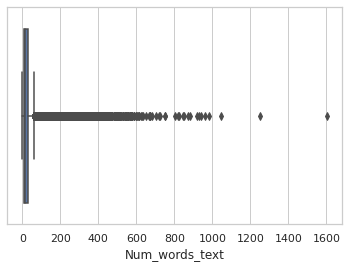

In [12]:
sns.set(style="whitegrid")
sns.boxplot(review_data['Num_words_text'])

In [13]:
mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
print('No of Short reviews')
print(len(df_short_reviews))

mask = review_data['Num_words_text'] >= 100
df_long_reviews = review_data[mask]
print('No of Long reviews')
print(len(df_long_reviews))

No of Short reviews
281480
No of Long reviews
19233


In [14]:
print(df_short_reviews['Num_words_text'].max())

99


In [15]:
def get_sentiment(rating):
  if rating > 3:
    return 1
  elif rating == 3:
    return 2
  else:
    return 0

In [16]:
filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 20)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)

train_data = filtered_data[['reviewText','sentiment']]
print('Train data')
print(train_data['sentiment'].value_counts())

#Create Test Data
mask = review_data['Num_words_text'] < 100 
df_short_reviews = review_data[mask]
filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 10)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)

test_data = filtered_data[['reviewText','sentiment']]
print('Test data')
print(test_data['sentiment'].value_counts())


94768
5.0    47104
4.0    19132
3.0    11596
1.0     9406
2.0     7530
Name: rating, dtype: int64
Train data
1    66236
0    16936
2    11596
Name: sentiment, dtype: int64
433782
5.0    225104
4.0     75616
1.0     51790
3.0     48706
2.0     32566
Name: rating, dtype: int64
Test data
1    300720
0     84356
2     48706
Name: sentiment, dtype: int64


In [17]:
train_data['sentiment'].value_counts()

1    66236
0    16936
2    11596
Name: sentiment, dtype: int64

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['reviewText'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.4,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:56860
Class distributionCounter({1: 39741, 0: 10161, 2: 6958})
Valid data len:37908
Class distributionCounter({1: 26495, 0: 6775, 2: 4638})


In [19]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)

print(str(tokenizer.texts_to_sequences(['how was your day'])))
print(str(tokenizer.texts_to_sequences(['how are you'])))
print(X_train[:5])

[[113, 7, 69, 119]]
[[113, 11, 18]]
['these actually come just under knee and they say cotton but they are not just cotton they are very hot and the fabric pills after washing', 'love this outfit sons baptism was mid july wanted something cool thin but cute love that its cotton and made the usa the small side3 months 12lbs the size was perfect was plenty big but not overly ordered the size well just sure but will return', 'these look adorable granddaughter however bought them for her newborn and she just now getting wear them months old because they are large and would not stay her feet until now still love them they match many outfits', 'the spanks them feels like less then becouse bought some other ones earlier and they were feel tighter and they bag out are long', 'for the money wrongly assumed would getting quality product purchased set for husband and our son couldnt more disappointed the fit terrible they are made about sizes too big mine came with several holes from careless sti

In [20]:
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['reviewText'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=100)
x_valid = pad_sequences(x_valid, padding='post', maxlen=100)
x_test = pad_sequences(x_test, padding='post', maxlen=100)



train_labels = np.asarray(y_train )
valid_labels = np.asarray( y_valid)

test_labels = np.asarray(test_data['sentiment'].tolist())

print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Validation data len:'+str(len(x_valid)))
print('Class distribution'+str(Counter(valid_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Train data len:56860
Class distributionCounter({1: 39741, 0: 10161, 2: 6958})
Validation data len:37908
Class distributionCounter({1: 26495, 0: 6775, 2: 4638})
Test data len:433782
Class distributionCounter({1: 300720, 0: 84356, 2: 48706})


In [21]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break  

======Train dataset ====
tf.Tensor(
[  15  202  257   24  219  782    3    8  214  491    6    8   11    9
   24  491    8   11   14  503    3    2  140 5066   78  600    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int32) tf.Tensor(0, shape=(), dtype=int64)
======Validation dataset ====
tf.Tensor(
[   2   68  114   34   97    4    2   53   41   17  193    6    2   21
   75   33  342   41  152   17  193   23   12  109   35    4    2  378
    6 1082   23   12  109   28   70   14  349    3  779  314  152    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [20]:
max_features =50000
embedding_dim =16
sequence_length = 100
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(3,activation='softmax'))

model.summary()
model.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(1e-3),metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           800016    
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 16)           2112      
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               819712    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4

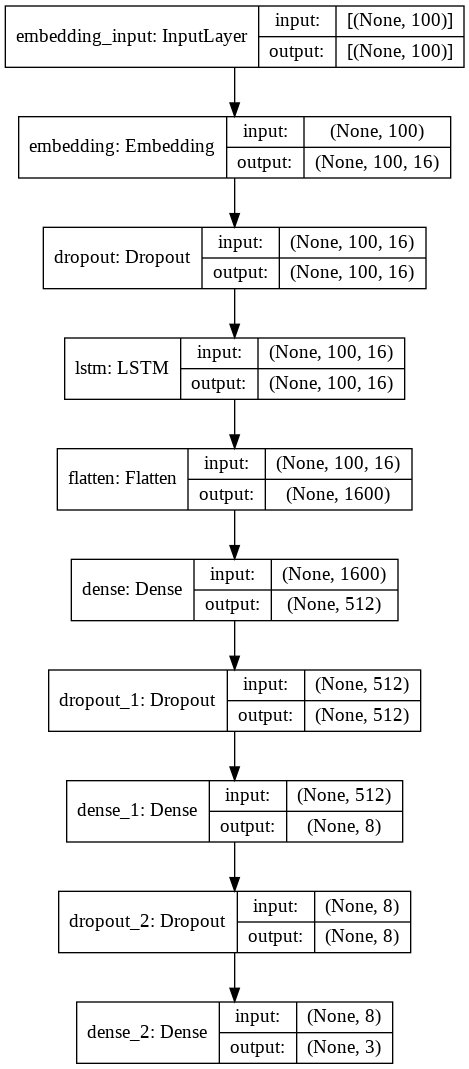

In [21]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
epochs = 11
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(x_train,train_labels,epochs=epochs,validation_data=(x_valid,valid_labels),batch_size=1024)

Epoch 1/11
56/56 [==============================] - 34s 547ms/step - loss: 2.1713 - acc: 0.6874 - val_loss: 0.9470 - val_acc: 0.6989
Epoch 2/11
56/56 [==============================] - 31s 545ms/step - loss: 0.8594 - acc: 0.6960 - val_loss: 0.7452 - val_acc: 0.6989
Epoch 3/11
56/56 [==============================] - 31s 547ms/step - loss: 0.7683 - acc: 0.6974 - val_loss: 0.7001 - val_acc: 0.6989
Epoch 4/11
56/56 [==============================] - 31s 548ms/step - loss: 0.7369 - acc: 0.7233 - val_loss: 0.6853 - val_acc: 0.7921
Epoch 5/11
56/56 [==============================] - 30s 543ms/step - loss: 0.7180 - acc: 0.7803 - val_loss: 0.6676 - val_acc: 0.7875
Epoch 6/11
56/56 [==============================] - 30s 539ms/step - loss: 0.7061 - acc: 0.7825 - val_loss: 0.6600 - val_acc: 0.7995
Epoch 7/11
56/56 [==============================] - 30s 542ms/step - loss: 0.6927 - acc: 0.7848 - val_loss: 0.6524 - val_acc: 0.7942
Epoch 8/11
56/56 [==============================] - 31s 547ms/step - 

In [ ]:
history.history

{'acc': [0.6873725056648254,
  0.6959725618362427,
  0.697361946105957,
  0.723267674446106,
  0.7802848815917969,
  0.7824832797050476,
  0.7847871780395508,
  0.7882870435714722,
  0.7892543077468872,
  0.7902039885520935,
  0.7888322472572327],
 'loss': [2.17134165763855,
  0.8594469428062439,
  0.7682721018791199,
  0.7369063496589661,
  0.7180485725402832,
  0.7061262130737305,
  0.6926541924476624,
  0.6827670335769653,
  0.6730905175209045,
  0.6668108701705933,
  0.6610226035118103],
 'val_acc': [0.6989290118217468,
  0.6989290118217468,
  0.6989290118217468,
  0.792128324508667,
  0.7874854803085327,
  0.7995409965515137,
  0.7941595315933228,
  0.7943178415298462,
  0.7971668243408203,
  0.8024691343307495,
  0.8052126169204712],
 'val_loss': [0.946965754032135,
  0.745193362236023,
  0.7000683546066284,
  0.6852627992630005,
  0.6675934195518494,
  0.6600141525268555,
  0.652369499206543,
  0.6456267833709717,
  0.6503986120223999,
  0.6257326602935791,
  0.6258768439292908]

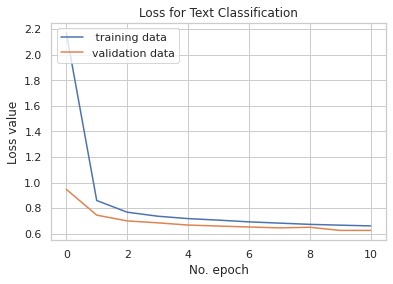

In [ ]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

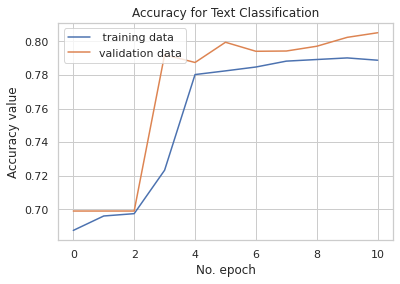

In [ ]:
plt.plot(history.history['acc'], label=' training data')
plt.plot(history.history['val_acc'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [39]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

model1 = svm.SVC(kernel='linear',random_state= 42)
model1.fit(x_train[:70],train_labels[:70])


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [40]:
y_pred = model1.predict(x_valid[:30])
print(y_pred)

[1 1 1 0 1 2 1 0 0 1 0 1 2 1 1 1 1 0 1 1 1 1 1 1 1 1 2 1 1 0]


In [37]:
from sklearn.metrics import confusion_matrix

confusion_matrix(valid_labels[:30],y_pred)

array([[ 0,  4,  1],
       [ 6, 14,  1],
       [ 1,  3,  0]])

In [38]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(valid_labels[:30],y_pred))

Accuracy: 0.4666666666666667
